# The Battle of Alberta - Clustering Neighbourhoods in Calgary and Edmonton

## Introduction

The **Battle of Alberta** is used to refer to the rivalry between the two largest cities in the province of Alberta, Canada - Calgary and Edmonton. The term  is mostly used in comparing sporting events between sports teams in these two cities. However, it is sometimes used in any comparison between these two cities. For more about the origins of the Battle of Alberta, see the [wikipedia page](https://en.wikipedia.org/wiki/Battle_of_Alberta).
Edmonton is the administrative capital of the province, whilst Calgary is the largest city in the province and also recognised as a leader in the Canadian oil and gas industry.

While public discourse focuses on their differences, these two cities are mostly similar whether it be about their demographics, the outdoor and urban adventures they offer, the food scene and urban planning.

## Business Problem

The aim of this project is to determine how similar Calgary and Edmonton are, in terms of the experiences neighbourhoods in each city have to offer. This will not only contribute to the Battle of Alberta debate but can also help anyone looking to settle or emigrate to Alberta make a decision. To this end, recommendations will be provided  to advise a person on a limited budget looking to settle in Alberta.

## Data Description

To solve this problem, we will require three datasets. The three required sets of data are: neighbourhood data, geographical location data and real estate pricing data. Postal codes in the two cities will be used in obtaining the two sets of data.
Information about the various venues in a specific neighbourhood is also required. For this, the Foursquare API will be used to get this data.

### Neighbourhood Data

The location data will be obtained by scraping postal codes information on [wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T) for Alberta. The information on wikipedia has postal codes by borough and neighbourhood names, this will help us limit ourselves to Calgary and Edmonton. The wikipedia page also has latitude and longitudes for all postal codes. The neighbourhood data will consist of the following:
* Postal code
* Borough
* Neighbourhood
* Latitude
* Longitude

### Real Estate Pricing Data
To get the real estate pricing data, the HousePriceHub [website](https://housepricehub.com/) will be scrapped for house pricing in Calgary and Edmonton. HousePriceHub tracks the listing prices of houses in Canada, as well as provides insights on the real estate market in Canada. The real estate pricing data will consist of the following:
* Postal code
* Average Price
* Total listings

### Foursquare API Data
In order to get specific neighbourhood information, the Foursquare API will be used. Foursquare is a geographical location data provider with information about venues and events within an area of interest. This location data includes venue names, locations, menus, photos and sometimes ratings. The neighbourhood information of Calgary and Edmonton will be connected to the Foursquare API and venues in each neighbourhood within a 500 meter radius will be obtained. The Foursquare API data will consist of the following:
* Neighbourhood
* Neighbourhood Latitude
* Neighbourhood Longitude
* Venue
* Venue Name
* Venue Latitude
* Venue Longitude
* Venue Category

These three data sets will assist us in determining the similarities between neighbourhoods in Calgary and Edmonton.

## Methodology
The problem to be solved involves grouping various neighbourhoods in both cities based on their similarities. To this end, neighbourhoods will be explored, segmented and grouped to find similar neighbourhoods. This will be approached analytically by using the KMeans clustering algorithm. All the neighbourhoods in Calgary and Edmonton will be explored to find the 10 most common venue categories in each neighbourhood and cluster them using KMeans clustering.

Finally, the most similar neighbourhoods will be selected and their real estate prices compared. A recommendation will be provided to advise a person looking to settle in Alberta with a limited budget on which city to choose.

### Data Extraction
We will now scrape the data needed for this project

In [1]:
# Import packages for this project

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
mpl.style.use('ggplot') 

import seaborn as sns

#!conda install -c conda-forge folium=0.5.0 --yes 

import folium

#import geocoder
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

%matplotlib inline

#### Nieghbourhood Data

In [2]:
# Set up the url and send request
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T'
html_data = requests.get(url).text

In [3]:
soup = BeautifulSoup(html_data, 'html.parser')
#print(soup.prettify())

In [4]:
# Get table
tables = soup.find_all('table')
#table

The table we want is found in the second table from inspection.

In [5]:
headers = tables[1].find_all('th')
headers

[<th>Postal Code
 </th>,
 <th>Borough
 </th>,
 <th>Neighborhood
 </th>,
 <th>Latitude
 </th>,
 <th>Longitude
 </th>]

In [6]:
# Convert the table into a dataframe
df_alberta = pd.read_html(str(tables[1]), flavor = 'bs4')[0]
df_alberta = df_alberta[df_alberta.Latitude != 'Not assigned'].reset_index(drop = True)
df_alberta.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [7]:
# Check data types and convert them
df_alberta.dtypes

Postal Code     object
Borough         object
Neighborhood    object
Latitude        object
Longitude       object
dtype: object

In [8]:
# Convert the data types of latitudes and longitudes to float
df_alberta = df_alberta.astype({'Latitude': float, 'Longitude': float})
df_alberta.dtypes

Postal Code      object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [9]:
df_alberta.shape

(138, 5)

In [10]:
# Slice the dataframe for Calgary and Edmonton Neighbourhoods
cgyedm = ['Calgary', 'Edmonton']
cgyedm_boroughs = '|'.join(cgyedm)

df_cgyedm = df_alberta[df_alberta['Borough'].str.contains(cgyedm_boroughs)].reset_index(drop = True)
df_cgyedm.head()
print("\nThe Calgary and Edmonton datafrme has {} rows.".format(df_cgyedm.shape[0]))


The Calgary and Edmonton datafrme has 72 rows.


In [11]:
# Slice the dataframe for Calgary and Edmonton Neighbourhoods
cgyedm = ['Calgary', 'Edmonton']
cgyedm_boroughs = '|'.join(cgyedm)

df_cgyedm = df_alberta[df_alberta['Borough'].str.contains(cgyedm_boroughs)].reset_index(drop = True)
df_cgyedm.head()
print("\nThe Calgary and Edmonton datafrme has {} rows.".format(df_cgyedm.shape[0]))


The Calgary and Edmonton datafrme has 72 rows.


In [12]:
# Extract the neighbourhoods in the different cities for plotting

df_cgy = df_alberta[df_alberta.Borough == 'Calgary'].reset_index(drop = True)
print("\nThe Calgary datafrme has {} rows.".format(df_cgy.shape[0]))

df_edm = df_alberta[df_alberta.Borough == 'Edmonton'].reset_index(drop = True)
print("\nThe Edmonton datafrme has {} rows.".format(df_edm.shape[0]))


The Calgary datafrme has 34 rows.

The Edmonton datafrme has 38 rows.


#### Plot the maps of Calgary and Edmonton

In [13]:
# Coordinatates for Calgary

calgary = 'Calgary, Alberta'

geolocator = Nominatim(user_agent = 'calgary_explorer')
location_cgy = geolocator.geocode(calgary)
latitude_cgy = location_cgy.latitude
longitude_cgy = location_cgy.longitude

print('The geographical coordinates of Calgary are {} and {}.'.format(latitude_cgy, longitude_cgy))

The geographical coordinates of Calgary are 51.0534234 and -114.0625892.


In [14]:
# Map of Calgary

map_cgy = folium.Map(location = [latitude_cgy, longitude_cgy], zoom_start = 11)

# Add marks
for lat, lng, hood in zip(df_cgy['Latitude'], df_cgy['Longitude'], df_cgy['Neighborhood']):
    label = hood
    label = folium.Popup(label, parse_html = True)
    
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(map_cgy)
    
map_cgy

In [15]:
# Coordinatates for Edmonton

edmonton = 'Edmonton, Alberta'

geolocator = Nominatim(user_agent = 'edmonton_explorer')
location_edm = geolocator.geocode(edmonton)
latitude_edm = location_edm.latitude
longitude_edm = location_edm.longitude

print('The geographical coordinates of Edmonton are {} and {}.'.format(latitude_edm, longitude_edm))

The geographical coordinates of Edmonton are 53.535411 and -113.507996.


In [16]:
# Map of Edmonton

map_edm = folium.Map(location = [latitude_edm, longitude_edm], zoom_start = 11)

# Add marks
for lat, lng, hood in zip(df_edm['Latitude'], df_edm['Longitude'], df_edm['Neighborhood']):
    label = hood
    label = folium.Popup(label, parse_html = True)
    
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(map_edm)
    
map_edm

#### Real Estate Pricing Data

In [17]:
# Calgary House Prices

cgy_url = "https://housepricehub.com/cities/city/Calgary"
cgy_data = requests.get(cgy_url).text

cgy_soup = BeautifulSoup(cgy_data, 'html.parser')
#print(cgy_soup.prettify())

cgy_table = cgy_soup.find_all('table')[0]
#cgy_tables

In [18]:
df_cgyhsepr = pd.read_html(str(cgy_table), flavor = 'bs4')[0]
#df_cgyhsepr = df_cgyhsepr.astype()

# Clean data
df_cgyhsepr['Average Price'] = df_cgyhsepr['Average Price'].str.replace('$', '', regex = True).str.replace(',', '')
df_cgyhsepr = df_cgyhsepr.astype({'Average Price': float})
df_cgyhsepr = df_cgyhsepr.drop(['Average Price Per Frontage Ft', 'Average Price Trend'], axis = 1)
print("The Calgary housing price data set has {} rows.\n".format(df_cgyhsepr.shape[0]))
df_cgyhsepr.head()

The Calgary housing price data set has 39 rows.



,Postal Code,City,Average Price,Total listings
0,T2S,Calgary,1516309.0,72
1,T3S,Calgary,1468580.0,5
2,T2T,Calgary,1320692.0,146
3,T2R,Calgary,1107493.0,2
4,T2N,Calgary,1102771.0,155


In [19]:
# Edmonton House Prices

edm_url = "https://housepricehub.com/cities/city/Edmonton"
edm_data = requests.get(edm_url).text

edm_soup = BeautifulSoup(edm_data, 'html.parser')
#print(edm_soup.prettify())

edm_table = edm_soup.find_all('table')[0]
#edm_tables

In [20]:
df_edmhsepr = pd.read_html(str(edm_table), flavor = 'bs4')[0]
#df_edmhsepr = df_edmhsepr.astype()

# Clean data
df_edmhsepr['Average Price'] = df_edmhsepr['Average Price'].str.replace('$', '', regex = True).str.replace(',', '')
df_edmhsepr = df_edmhsepr.astype({'Average Price': float})
df_edmhsepr = df_edmhsepr.drop(['Average Price Per Frontage Ft', 'Average Price Trend'], axis = 1)
print("The Edmonton housing price data set has {} rows.\n".format(df_edmhsepr.shape[0]))
df_edmhsepr.head()

The Edmonton housing price data set has 49 rows.



,Postal Code,City,Average Price,Total listings
0,T6Y,Edmonton,1645000.0,4
1,T6N,Edmonton,1147000.0,2
2,T6G,Edmonton,1015003.0,92
3,T7H,Edmonton,998000.0,1
4,T5N,Edmonton,942932.0,79


In [21]:
# Append the two datasets

df_cgyedmhsepr = df_cgyhsepr.append(df_edmhsepr).reset_index(drop = True).drop('City', axis = 1)

df_cgyedmhsepr['Average Price (1000s)'] = df_cgyedmhsepr['Average Price']/1000
df_cgyedmhsepr = df_cgyedmhsepr.drop('Average Price', axis = 1)
print("The Calgary and Edmonton housing price data set has {} rows.\n".format(df_cgyedmhsepr.shape[0]))
df_cgyedmhsepr.head()

The Calgary and Edmonton housing price data set has 88 rows.



,Postal Code,Total listings,Average Price (1000s)
0,T2S,72,1516.309
1,T3S,5,1468.580
2,T2T,146,1320.692
3,T2R,2,1107.493
4,T2N,155,1102.771


#### Foursquare API Data

In [22]:
# Foursquare credentials

CLIENT_ID = '' 
CLIENT_SECRET = '' 
VERSION = '20180605' 
LIMIT = 100 # A default Foursquare API limit value

#### Explore one random neighbourhood in Caglary or Edmonton

In [23]:
# select a random integer

cgyedm_int = np.random.randint(0, 73, size = 1)
print(cgyedm_int)

[11]


In [24]:
hood_nm = df_cgyedm.loc[int(cgyedm_int), 'Neighborhood']
city_nm = df_cgyedm.loc[int(cgyedm_int), 'Borough']
hood_lat = df_cgyedm.loc[int(cgyedm_int), 'Latitude']
hood_lng = df_cgyedm.loc[int(cgyedm_int), 'Longitude']

print('The latitude and longitude of {}, {} are {} and {}.'.format(hood_nm, city_nm, hood_lat, hood_lng))

The latitude and longitude of Central Bonnie Doon, Edmonton are 53.5182 and -113.4769.


In [25]:
# Set up url for Foursquare

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    hood_lat, 
    hood_lng, 
    radius, 
    LIMIT)

In [26]:
# Send request and examine results
results = requests.get(url).json()
#results # uncomment to see results

In [27]:
# Function to get categories
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues = results['response']['groups'][0]['items']

nearby_venues = pd.json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Mill Creek Cafe and Eatery,American Restaurant,53.518081,-113.476574
1,Mill Creek Outdoor Pool,Water Park,53.519652,-113.473878
2,Color De Vino,Liquor Store,53.518213,-113.477153
3,Earth's General Store - Whyte Avenue,Grocery Store,53.517927,-113.477084
4,Mill Creek Ravine South,Trail,53.515201,-113.481496


In [29]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


Now let us generalize to obtain all the venues in Calgary and Edmonton

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    # Initialize venues list
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        # Make the get request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        #print(venues_list)
        #print('\n')
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    return(nearby_venues)

In [31]:
cgyedm_venues = getNearbyVenues(names = df_cgyedm['Neighborhood'],
                                        latitudes = df_cgyedm['Latitude'],
                                        longitudes = df_cgyedm['Longitude'])
cgyedm_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
print("There are {} venues returned for Calgary and Edmonton.".format(
    cgyedm_venues.shape[0]
))

There are 649 venues returned for Calgary and Edmonton.


In [32]:
cgyedm_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Petro-Canada,51.128068,-114.138057,Gas Station
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Edgemont City,51.126473,-114.138997,Asian Restaurant
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Friends Cappuccino Bar & Bake Shop,51.126370,-114.138676,Café
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Mac's,51.128309,-114.137902,Convenience Store
4,"West Clareview, East Londonderry",53.58990,-113.441300,Buffet Royale Carvery,53.587229,-113.439075,Buffet


In [33]:
# Number of venues returned for each neighbourd

cgyedm_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",9,9,9,9,9,9
"Brentwood, Collingwood, Nose Hill",1,1,1,1,1,1
"Bridgeland, Greenview, Zoo, YYC",25,25,25,25,25,25
Central Beverly,4,4,4,4,4,4
Central Bonnie Doon,5,5,5,5,5,5
...,...,...,...,...,...,...
West Lake District,19,19,19,19,19,19
"West Londonderry, East Calder",9,9,9,9,9,9
West Mill Woods,3,3,3,3,3,3


In [34]:
print('There are {} uniques categories.'.format(len(cgyedm_venues['Venue Category'].unique())))

There are 174 uniques categories.


#### Analyze the Neighbourhoods in Calgary and Edmonton

In [35]:
# One hot encoding
cgyedm_onehot = pd.get_dummies(cgyedm_venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighbourhood column to encoding
cgyedm_onehot['Neighborhood'] = cgyedm_venues['Neighborhood']

# Move Neighbourhood column in encoding as first column
neigh_cols = [cgyedm_onehot.columns[-1]] + list(cgyedm_onehot.columns[:-1])

cgyedm_onehot = cgyedm_onehot[neigh_cols]
cgyedm_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,...,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Shop,Yoga Studio
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
print('The encoded dataframe has {} rows and {} columns.'.format(cgyedm_onehot.shape[0], cgyedm_onehot.shape[1]))

The encoded dataframe has 649 rows and 175 columns.


Group venues by neighbourhood by taking the mean of the frequency of occurrence by each category.

In [37]:
cgyedm_grp = cgyedm_onehot.groupby('Neighborhood').mean().reset_index()

cgyedm_grp.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,...,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,"Brentwood, Collingwood, Nose Hill",0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,"Bridgeland, Greenview, Zoo, YYC",0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.04,0.04,...,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0
3,Central Beverly,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,Central Bonnie Doon,0.2,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.0,0.0,0.0


In [38]:
print('\nThe grouped dataframe has {} rows.'.format(cgyedm_grp.shape[0]))


The grouped dataframe has 68 rows.


Get the most common 'N' venues for each neighbourhood.

In [39]:
def return_most_common_venues(row, N):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:N]

In [40]:
N = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(N):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))
        
# New dataframe
hoods_venues_sorted = pd.DataFrame(columns = columns)
hoods_venues_sorted['Neighborhood'] = cgyedm_grp['Neighborhood']

for ind in np.arange(cgyedm_grp.shape[0]):
    hoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cgyedm_grp.iloc[ind, :], N)
    
hoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Pub,Convenience Store,Gas Station,Gym,Pharmacy,Pizza Place,Coffee Shop,Hockey Rink,Ice Cream Shop,Office
1,"Brentwood, Collingwood, Nose Hill",Dog Run,American Restaurant,Paintball Field,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House
2,"Bridgeland, Greenview, Zoo, YYC",Fast Food Restaurant,Restaurant,Pizza Place,Seafood Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Gym / Fitness Center,Sandwich Place,Noodle House,Brewery
3,Central Beverly,Construction & Landscaping,Smoke Shop,Grocery Store,American Restaurant,Office,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant
4,Central Bonnie Doon,American Restaurant,Water Park,Liquor Store,Trail,Grocery Store,Noodle House,Motorcycle Shop,Movie Theater,Multiplex,Museum


#### Cluster Neighbourhoods

In [41]:
# Number of clusters
clusters = 5

cgyedm_grp_cl = cgyedm_grp.drop('Neighborhood', 1)

# KMeans clustering
km = KMeans(n_clusters = clusters, random_state = 125).fit(cgyedm_grp_cl)

# Check cluster labels generated
km.labels_[0:N]

array([4, 0, 0, 1, 0, 4, 1, 0, 0, 4], dtype=int32)

In [42]:
# Add cluster labels

hoods_venues_sorted.insert(0, 'Cluster Label', km.labels_)

cgyedm_merged = df_cgyedm

# Add latitudes and longitudes information
cgyedm_merged = cgyedm_merged.join(hoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
cgyedm_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,4.0,Café,Asian Restaurant,Gas Station,Convenience Store,American Restaurant,Paintball Field,Multiplex,Museum,Music Venue,New American Restaurant
2,T5A,Edmonton,"West Clareview, East Londonderry",53.58990,-113.441300,0.0,Record Shop,Toy / Game Store,Mexican Restaurant,Buffet,Bus Station,Inn,Insurance Office,Movie Theater,Multiplex,Museum
3,T6A,Edmonton,North Capilano,53.54830,-113.408000,0.0,Bus Station,Playground,Construction & Landscaping,Ski Trail,Park,Noodle House,Movie Theater,Multiplex,Museum,Music Venue
4,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,4.0,Smoke Shop,Convenience Store,Bar,American Restaurant,Office,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant


In [43]:
cgyedm_merged.shape

(72, 16)

In [44]:
# Some neighbourhood cluster labels are NaN. Drop them.
cgyedm_merged = cgyedm_merged.dropna().reset_index(drop = True)
cgyedm_merged.shape

(69, 16)

In [45]:
# Separate the Clusters for the two cities for later visualization

cgy_merged = cgyedm_merged[cgyedm_merged.Borough == 'Calgary']
print("The Calgary dataset has {} rows".format(cgy_merged.shape[0]))

edm_merged = cgyedm_merged[cgyedm_merged.Borough == 'Edmonton']
print("The Edmonton dataset has {} rows".format(edm_merged.shape[0]))

The Calgary dataset has 33 rows
The Edmonton dataset has 36 rows


## Results

### Visualize the Clusters

In [46]:
# Calgary Clusters
cgymap_clusters = folium.Map(location = [latitude_cgy, longitude_cgy], zoom_start = 10)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lng, hood, cluster in zip(cgy_merged['Latitude'], cgy_merged['Longitude'], 
                                  cgy_merged['Neighborhood'], cgy_merged['Cluster Label']):
    label = folium.Popup(str(hood) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster - 1)],
        fill = True,
        fill_color = rainbow[int(cluster - 1)],
        fill_opacity = 0.7).add_to(cgymap_clusters)
    
cgymap_clusters

In [47]:
# Edmonton Clusters
edmmap_clusters = folium.Map(location = [latitude_edm, longitude_edm], zoom_start = 10)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lng, hood, cluster in zip(edm_merged['Latitude'], edm_merged['Longitude'], 
                                  edm_merged['Neighborhood'], edm_merged['Cluster Label']):
    label = folium.Popup(str(hood) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster - 1)],
        fill = True,
        fill_color = rainbow[int(cluster - 1)],
        fill_opacity = 0.7).add_to(edmmap_clusters)
    
edmmap_clusters

#### Explore the different Clusters

Cluster 1

In [48]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 0, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Edmonton,"West Clareview, East Londonderry",0.0,Record Shop,Toy / Game Store,Mexican Restaurant,Buffet,Bus Station,Inn,Insurance Office,Movie Theater,Multiplex,Museum
2,Edmonton,North Capilano,0.0,Bus Station,Playground,Construction & Landscaping,Ski Trail,Park,Noodle House,Movie Theater,Multiplex,Museum,Music Venue
4,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",0.0,Food Court,Steakhouse,Coffee Shop,Scenic Lookout,American Restaurant,Noodle House,Movie Theater,Multiplex,Museum,Music Venue
8,Calgary,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",0.0,Pub,Indian Restaurant,Mexican Restaurant,Sandwich Place,Middle Eastern Restaurant,Bookstore,Fried Chicken Joint,Candy Store,Spa,Pizza Place
9,Edmonton,Central Bonnie Doon,0.0,American Restaurant,Water Park,Liquor Store,Trail,Grocery Store,Noodle House,Motorcycle Shop,Movie Theater,Multiplex,Museum
10,Calgary,"Bridgeland, Greenview, Zoo, YYC",0.0,Fast Food Restaurant,Restaurant,Pizza Place,Seafood Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Gym / Fitness Center,Sandwich Place,Noodle House,Brewery
12,Edmonton,"West Londonderry, East Calder",0.0,Comic Shop,Arts & Crafts Store,Recreation Center,Dog Run,Butcher,Bakery,Baseball Field,Hockey Arena,Grocery Store,Paintball Field
13,Edmonton,"South Bonnie Doon, East University",0.0,American Restaurant,Flower Shop,Mediterranean Restaurant,Pharmacy,Coffee Shop,Office,Multiplex,Museum,Music Venue,New American Restaurant
14,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria...",0.0,Coffee Shop,Hotel,Pub,Theater,Performing Arts Venue,Asian Restaurant,Deli / Bodega,Cocktail Bar,New American Restaurant,Italian Restaurant
16,Edmonton,"North Central, Queen Mary Park, Blatchford",0.0,Café,Pharmacy,Bakery,Bank,Vietnamese Restaurant,Music Venue,Grocery Store,Noodle House,Motorcycle Shop,Movie Theater


In [49]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 0, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]].groupby(['Borough']).count()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,
Calgary,19,19,19,19,19,19,19,19,19,19,19,19
Edmonton,25,25,25,25,25,25,25,25,25,25,25,25


Cluster 2

In [50]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 1, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Edmonton,"East North Central, West Beverly",1.0,Construction & Landscaping,Smoke Shop,Grocery Store,American Restaurant,Office,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant
6,Edmonton,"SE Capilano, West Southeast Industrial, East B...",1.0,Home Service,Playground,Construction & Landscaping,Bar,American Restaurant,Paintball Field,Multiplex,Museum,Music Venue,New American Restaurant
11,Calgary,"Lakeview, Glendale, Killarney, Glamorgan",1.0,Coffee Shop,Wine Shop,Business Service,Plaza,Playground,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue
29,Edmonton,West Mill Woods,1.0,Business Service,Home Service,Construction & Landscaping,Paintball Field,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub
56,Edmonton,Central Mistatim,1.0,Warehouse Store,Casino,Construction & Landscaping,Liquor Store,Business Service,American Restaurant,Office,Multiplex,Museum,Music Venue
59,Edmonton,Central Beverly,1.0,Construction & Landscaping,Smoke Shop,Grocery Store,American Restaurant,Office,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant


In [51]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 1, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]].groupby(['Borough']).count()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,
Calgary,1,1,1,1,1,1,1,1,1,1,1,1
Edmonton,5,5,5,5,5,5,5,5,5,5,5,5


Cluster 3

In [52]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 2, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Edmonton,"Glenora, SW Downtown Fringe",2.0,Portuguese Restaurant,Miscellaneous Shop,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub


In [53]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 2, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]].groupby(['Borough']).count()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,
Edmonton,1,1,1,1,1,1,1,1,1,1,1,1


Cluster 4

In [54]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 3, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Calgary,Northwest Calgary,3.0,Flea Market,American Restaurant,Office,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House


In [55]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 3, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]].groupby(['Borough']).count()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,
Calgary,1,1,1,1,1,1,1,1,1,1,1,1


Cluster 5

In [56]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 4, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",4.0,Café,Asian Restaurant,Gas Station,Convenience Store,American Restaurant,Paintball Field,Multiplex,Museum,Music Venue,New American Restaurant
3,Calgary,"Forest Lawn, Dover, Erin Woods",4.0,Smoke Shop,Convenience Store,Bar,American Restaurant,Office,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant
7,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",4.0,Diner,Convenience Store,Pizza Place,Clothing Store,American Restaurant,Paper / Office Supplies Store,Museum,Music Venue,New American Restaurant,Nightclub
15,Calgary,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",4.0,Pub,Pizza Place,Office,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub
19,Calgary,"Discovery Ridge, Signal Hill, West Springs, Ch...",4.0,Gas Station,Convenience Store,Pizza Place,Vietnamese Restaurant,Bar,American Restaurant,Office,Movie Theater,Multiplex,Museum
22,Calgary,"Queensland, Lake Bonavista, Willow Park, Acadia",4.0,Pizza Place,Insurance Office,Child Care Service,Chinese Restaurant,American Restaurant,Office,Multiplex,Museum,Music Venue,New American Restaurant
26,Calgary,"Thorncliffe, Tuxedo Park",4.0,Vietnamese Restaurant,Home Service,BBQ Joint,Bar,Convenience Store,Fast Food Restaurant,American Restaurant,Paintball Field,Multiplex,Museum
31,Calgary,"Tuscany, Scenic Acres",4.0,Pub,Convenience Store,Pizza Place,Video Store,Pharmacy,Liquor Store,Chinese Restaurant,Office,Multiplex,Museum
35,Calgary,"Cranston, Auburn Bay, Mahogany",4.0,Cosmetics Shop,Pizza Place,Liquor Store,American Restaurant,Paintball Field,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub
43,Calgary,Symons Valley,4.0,Beer Bar,Home Service,Convenience Store,Paper / Office Supplies Store,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House


In [57]:
cgyedm_merged.loc[cgyedm_merged['Cluster Label'] == 4, cgyedm_merged.columns[[1, 2] + list(range(5, cgyedm_merged.shape[1]))]].groupby(['Borough']).count()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,
Calgary,12,12,12,12,12,12,12,12,12,12,12,12
Edmonton,5,5,5,5,5,5,5,5,5,5,5,5


#### Compare Real Estate Pricing in Calgary and Edmonoton

In [58]:
cluster_hsepr = pd.merge(cgyedm_merged, df_cgyedmhsepr, how = 'left', on = 'Postal Code')
cluster_hsepr = cluster_hsepr[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Average Price (1000s)', 
                               'Total listings', 'Cluster Label']] #.set_index(['Postal Code']) 
cluster_hsepr = cluster_hsepr.dropna(axis = 0, how = 'any')
cluster_hsepr.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Average Price (1000s),Total listings,Cluster Label
0,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,704.308,144.0,4.0
1,T5A,Edmonton,"West Clareview, East Londonderry",53.58990,-113.441300,356.929,62.0,0.0
2,T6A,Edmonton,North Capilano,53.54830,-113.408000,546.782,53.0,0.0
3,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,369.741,57.0,4.0
4,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,761.118,135.0,0.0


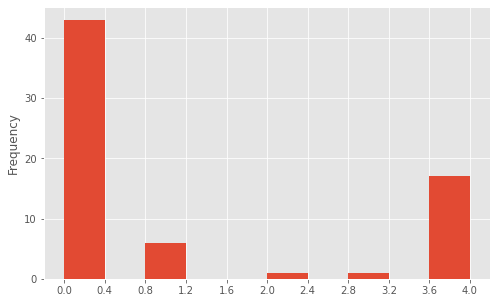

In [59]:
#cluster_hsepr.groupby([])

count, bins = np.histogram(cluster_hsepr['Cluster Label'])

cluster_hsepr['Cluster Label'].plot(kind='hist', figsize=(8, 5), xticks=bins)
plt.show()

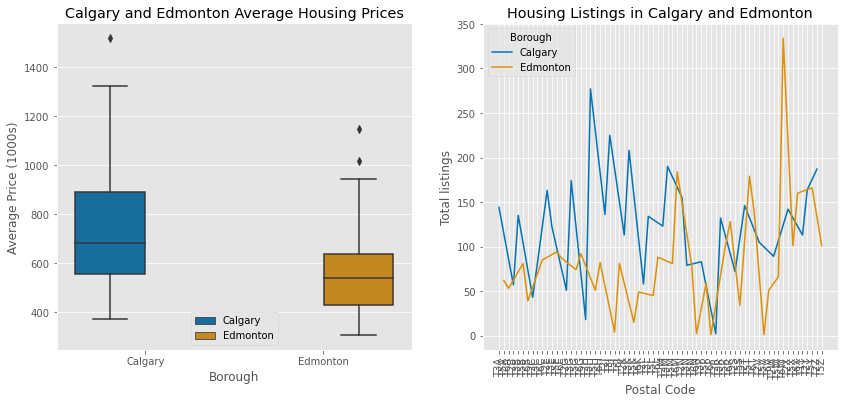

In [60]:
# Calgary and Edmonton House Pricing Compared
fig = plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data = cluster_hsepr, x = 'Borough', y = 'Average Price (1000s)', palette = 'colorblind', hue = 'Borough')
plt.title('Calgary and Edmonton Average Housing Prices')
plt.legend(loc = 'lower center')

plt.subplot(1, 2, 2)
sns.lineplot(data = cluster_hsepr, x = 'Postal Code', y = 'Total listings', hue = 'Borough', palette = 'colorblind')
plt.xticks(rotation = 90)
plt.title('Housing Listings in Calgary and Edmonton')

plt.show()

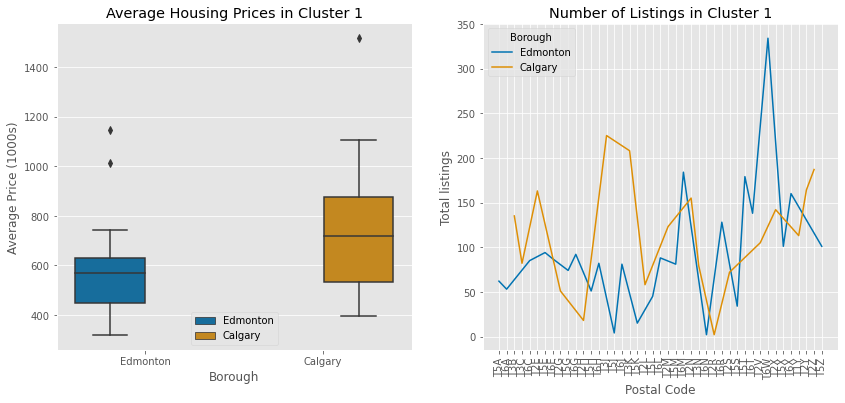

In [61]:
# Calgary and Edmonton House Pricing Compared - Cluster 1
fig = plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 0], x = 'Borough', y = 'Average Price (1000s)', 
            palette = 'colorblind', hue = 'Borough')
plt.title('Average Housing Prices in Cluster 1')
plt.legend(loc = 'lower center')

plt.subplot(1, 2, 2)
sns.lineplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 0], x = 'Postal Code', y = 'Total listings', 
             hue = 'Borough', palette = 'colorblind')
plt.xticks(rotation = 90)
plt.title('Number of Listings in Cluster 1')

plt.show()

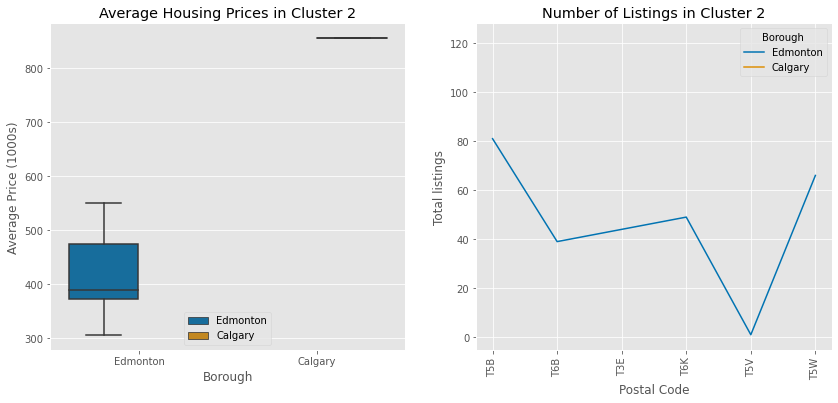

In [62]:
# Calgary and Edmonton House Pricing Compared - Cluster 2
fig = plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 1], x = 'Borough', y = 'Average Price (1000s)', 
            palette = 'colorblind', hue = 'Borough')
plt.title('Average Housing Prices in Cluster 2')
plt.legend(loc = 'lower center')

plt.subplot(1, 2, 2)
sns.lineplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 1], x = 'Postal Code', y = 'Total listings', 
             hue = 'Borough', palette = 'colorblind')
plt.xticks(rotation = 90)
plt.title('Number of Listings in Cluster 2')

plt.show()

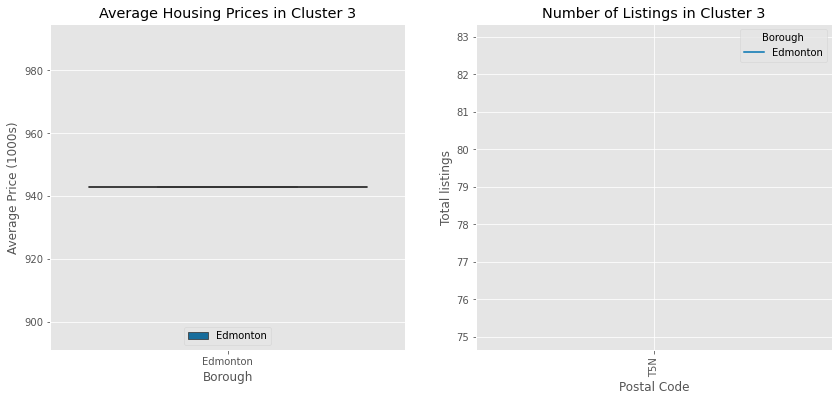

In [63]:
# Calgary and Edmonton House Pricing Compared - Cluster 3
fig = plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 2], x = 'Borough', y = 'Average Price (1000s)', 
            palette = 'colorblind', hue = 'Borough')
plt.title('Average Housing Prices in Cluster 3')
plt.legend(loc = 'lower center')

plt.subplot(1, 2, 2)
sns.lineplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 2], x = 'Postal Code', y = 'Total listings', 
             hue = 'Borough', palette = 'colorblind')
plt.xticks(rotation = 90)
plt.title('Number of Listings in Cluster 3')

plt.show()

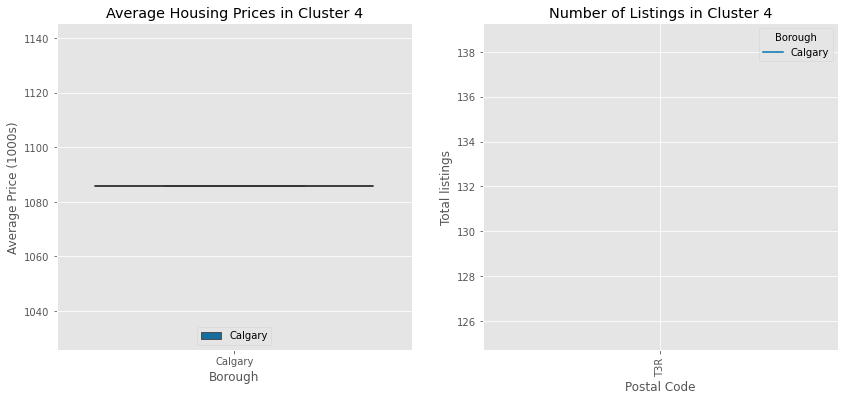

In [64]:
# Calgary and Edmonton House Pricing Compared - Cluster 4
fig = plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 3], x = 'Borough', y = 'Average Price (1000s)', 
            palette = 'colorblind', hue = 'Borough')
plt.title('Average Housing Prices in Cluster 4')
plt.legend(loc = 'lower center')

plt.subplot(1, 2, 2)
sns.lineplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 3], x = 'Postal Code', y = 'Total listings', 
             hue = 'Borough', palette = 'colorblind')
plt.xticks(rotation = 90)
plt.title('Number of Listings in Cluster 4')

plt.show()

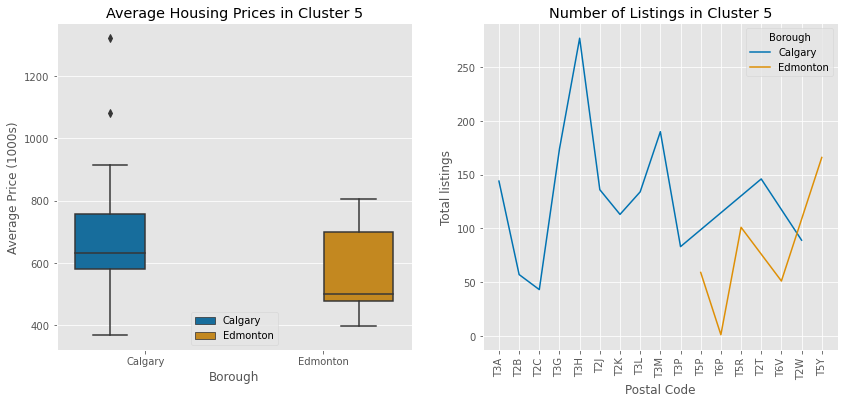

In [65]:
# Calgary and Edmonton House Pricing Compared - Cluster 5
fig = plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 4], x = 'Borough', y = 'Average Price (1000s)', 
            palette = 'colorblind', hue = 'Borough')
plt.title('Average Housing Prices in Cluster 5')
plt.legend(loc = 'lower center')

plt.subplot(1, 2, 2)
sns.lineplot(data = cluster_hsepr[cluster_hsepr['Cluster Label'] == 4], x = 'Postal Code', y = 'Total listings', 
             hue = 'Borough', palette = 'colorblind')
plt.xticks(rotation = 90)
plt.title('Number of Listings in Cluster 5')

plt.show()

## Discussion

The neighbourhoods in Calgary and Edmonton were grouped into 5 different clusters. Together 69 neighbourhoods were clustered, the majority (44) of which were in Cluster 1 representing over 50% of the total neighbourhoods. Cluster 5 was the next largest group of neighbourhoods with 19. Clusters 2, 3 and 4 had very few neighbourhoods between the two cities, with clusters 3 and 4 having only one neighbourhood of Edmonton and Calgary respectively.

The results of the clustering suggests that the majority of venues in the neighbourhoods of Calgary and Edmonton are similar. The venues in these neighbourhoods tend to be places like restaurants, fast food outlets, pubs, liquor stores, movie theaters and parks/museums among others.

The real estate pricing data showed that average housing prices are significantly higher in Calgary compared to Edmonton. There are comparatively the same number of listings in both cities. One observation from the plot of the maps is that Calgary tends to be spread out whilst Edmonton is more compact.

Overall, the two cities are similar and offer the same type of experiences in their neighbourhoods. The recommendation for someone on a limited budget looking to move to Alberta will be to settle in Edmonton due to the lower average real estate pricing for a more affordable and less sprawl for decreased commute time within the city. 

## Conclusion

The purpose of this project was to explore and group neighbourhoods in Calgary and Edmonton in terms of the experiences they offer, and to provide recommendations to a person on a limited budget looking to settle in Alberta on which of the two cities to choose. Neighbourhoods in both cities were explored based on their postal codes. Similar neighbourhoods were grouped together and real estate prices were compared.

It was observed that neighbourhoods in both cities offer similar experiences, and that real estate prices in Calgary are significantly higher than prices in Edmonton.

Based on the findings, the recommendation to a person on a limited budget looking to settle in Alberta was to choose to move to Edmonton. 
